In [4]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import re
import pathlib
from tqdm.notebook import tqdm
from time import time
import json

## Download ABO images as low resolution cutout

In [6]:
# ABO1550_1599 = pd.read_excel('data/ABO/ABO_1550-1599.xlsx')
ABO1501_1549 = pd.read_excel('data/ABO/predictions_BE_1501-1549.xlsx')
# ABO1600_1650 = pd.read_excel('data/ABO/predictions_BE_1600-1650.xlsx')

In [12]:
print(ABO1501_1549['Barcode'][ABO1501_1549['Barcode'].str.contains('Z119507708')])
print(ABO1501_1549['Barcode'][ABO1501_1549['Barcode'].str.contains('Z119507204')])

16058    Z119507708
Name: Barcode, dtype: object
1960    Z119507204
Name: Barcode, dtype: object


In [92]:
barcode_lis = 'Z155536301;\nZ155536404;\nZ15553660X;\nZ155536702'
single_barcode = 'Z155536301'
nan = 'NaN'

def split_bc_lis(entry):
    p = re.compile('(Z[0-9X]+)')
    match = p.findall(entry)
    return match

print(split_bc_lis(barcode_lis))
print(split_bc_lis(single_barcode))
print(split_bc_lis(nan))

# ABO1550_1599['barcode_list'] = ABO1550_1599['Barcode'].dropna().apply(lambda x: split_bc_lis(x))
# ABO1501_1549['barcode_list'] = ABO1501_1549['Barcode'].dropna().apply(lambda x: split_bc_lis(x))
# BC_series = ABO1550_1599['barcode_list'].explode().drop_duplicates().dropna()
BC_series = ABO1600_1650['Barcode']
print(len(BC_series))

['Z155536301', 'Z155536404', 'Z15553660X', 'Z155536702']
['Z155536301']
[]
23323


In [93]:
img_dir = pathlib.Path('img/ABO/1600_1650')
if not img_dir.exists():
    img_dir.mkdir()
dummy_dir = 'no_category'
img_dir = img_dir / dummy_dir
if not img_dir.exists():
    img_dir.mkdir()

before = time()
for bc in tqdm(BC_series):
    for i in range(5):
        page_num = format(i + 1, '08d')
        filename = img_dir / f'{bc}_{str(page_num)}.jpg'
        if not filename.exists():
            url = f'https://iiif.onb.ac.at/images/ABO/{bc}/{str(page_num)}/square/256,/0/native.jpg'
            resp = requests.get(url)
            if resp.status_code == 200:
                img_content = resp.content
                open(filename, 'wb').write(img_content)

print("time elapsed: ", time()-before)

  0%|          | 0/23323 [00:00<?, ?it/s]

time elapsed:  13105.970116853714


# Load the model and trained weights

In [2]:
model_ft = models.resnext50_32x4d()
num_ftrs = model_ft.fc.in_features
class_names = ['A', 'B', 'C', 'N']
model_ft.fc = torch.nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load('models/final_GT_resnext50_32x4d_finetuned.pth'))
model_ft.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

In [3]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.2138, 0.0986, 0.0467], [0.0856, 0.0697, 0.0405])
        transforms.Normalize([0.3227, 0.2076, 0.1405], [0.0816, 0.0715, 0.0502])
    ])

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # mean = np.array([0.2138, 0.0986, 0.0467])
    mean = np.array([0.3227, 0.2076, 0.1405])
    # std = np.array([0.229, 0.224, 0.225])
    # std = np.array([0.0856, 0.0697, 0.0405])
    std = np.array([0.0816, 0.0715, 0.0502])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def pretty_print_prediction(pred):
    sm = torch.softmax(pred, dim=1)
    lis = [f'{it.item():.2f}' for it in sm[0]]
    output = ', '.join(lis)
    return output
        
def visualize_model(model, num_images=8, data=None):
    images_so_far = 0
    cols = 8
    rows = int(np.ceil(num_images/cols))
    fig = plt.figure(figsize=(int(cols*2.5),int(rows*2.5)))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(rows, cols, images_so_far)
                ax.axis('off')
                ax.set_title(f'GT: {class_names[labels[j]]}, predicted: {class_names[preds[j]]}\n{pretty_print_prediction(outputs)}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

11


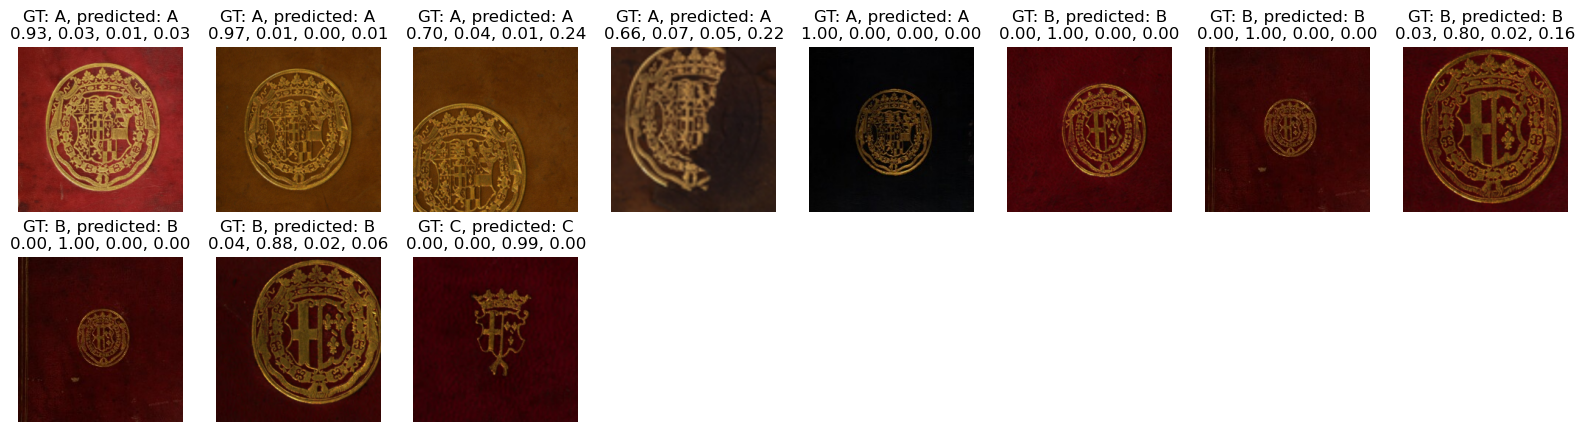

In [4]:
BED_add = datasets.ImageFolder('img/BED_testdata', data_transform)
BED_dl = torch.utils.data.DataLoader(BED_add)
print(len(BED_add))

visualize_model(model_ft, num_images=len(BED_add), data=BED_dl)

In [70]:
from PIL import Image

def display_images_from_dataframe(df, num_images=16):
    images_so_far = 0
    cols = 8
    rows = int(np.ceil(num_images/cols))
    fig = plt.figure(figsize=(int(cols*2.5),int(rows*2.5)))
    
    for i, data in enumerate(df.values):
        images_so_far += 1
        ax = plt.subplot(rows, cols, images_so_far)
        ax.axis('off')
        ax.set_title(f'{i}, P: {data[1]}, BP: {data[7]}')
        image = Image.open(f'img/ABO/{data[8]}/no_category/{data[0]}')
        plt.imshow(image)
        if images_so_far == num_images:
            return

In [11]:
ABO1501_1549 = datasets.ImageFolder('img/ABO/1501_1549/', data_transform)
ABO1550_1599 = datasets.ImageFolder('img/ABO/1550_1599/', data_transform)
ABO1600_1650 = datasets.ImageFolder('img/ABO/1600_1650/', data_transform)
ABO1651_1699 = datasets.ImageFolder('img/ABO/1651_1699/', data_transform)
ABO1700_1738 = datasets.ImageFolder('img/ABO/1700_1738/', data_transform)
ABO_dataset = torch.utils.data.ConcatDataset([ABO1501_1549, ABO1550_1599, ABO1600_1650, ABO1651_1699, ABO1700_1738])
ABO_dl = torch.utils.data.DataLoader(ABO_dataset, num_workers=4)
print(len(ABO_dl))

500433


In [40]:
def prettify_prediction(pred):
    sm = torch.softmax(pred, dim=1)
    lis = [it.item() for it in sm[0]]
    return lis

def get_indices_from_sizes(idx, cum_sizes):
    current_index = idx
    compare = [idx >= size for size in cum_sizes]
    dataset_index = compare.index(False)
    if dataset_index > 0:
        current_index = idx - cum_sizes[dataset_index - 1]
    return dataset_index, current_index

dummy_sizes = [80110, 209285, 325889, 474378, 500433]

print(get_indices_from_sizes(80109, dummy_sizes))
print(get_indices_from_sizes(80110, dummy_sizes))
print(get_indices_from_sizes(330000, dummy_sizes))
print(get_indices_from_sizes(500432, dummy_sizes))

(0, 80109)
(1, 0)
(3, 4111)
(4, 26054)


In [43]:
filenames = {}
probabilities = {}
predictions = {}

for i, (inputs, labels) in enumerate(tqdm(ABO_dl)):
    with torch.no_grad():
        inputs = inputs.to(device)
        pred = model_ft(inputs)
        predictions[i] = class_names[pred[0].argmax(0)]
        cumulative_sizes = ABO_dl.dataset.cumulative_sizes
        current_dataset_idx, current_idx = get_indices_from_sizes(i, cumulative_sizes)
        filename = ABO_dl.dataset.datasets[current_dataset_idx].samples[current_idx][0].split('/')[-1]
        filenames[i] = filename
        pretty_pred = prettify_prediction(pred)
        probabilities[i] = pretty_pred

pred_df = pd.DataFrame()
pred_df['filename'] = filenames
pred_df['prediction'] = predictions
pred_df['probability'] = probabilities
pred_df.to_csv('data/predictions/all_pred_1501_1738.csv', index=False)

  0%|          | 0/500433 [00:00<?, ?it/s]

In [2]:
# pred_df = pd.read_csv('data/predictions/pred_1600_1650.csv')

In [49]:
ds_sizes = [80110, 209285, 325889, 474378, 500433]

pred_df['p_A'] = pred_df['probability'].apply(lambda x: x[0])
pred_df['p_B'] = pred_df['probability'].apply(lambda x: x[1])
pred_df['p_C'] = pred_df['probability'].apply(lambda x: x[2])
pred_df['p_N'] = pred_df['probability'].apply(lambda x: x[3])

pred_df['years'] = ''
pred_df['years'].iloc[0:ds_sizes[0]] = '1501_1549'
pred_df['years'].iloc[ds_sizes[0]:ds_sizes[1]] = '1550_1599'
pred_df['years'].iloc[ds_sizes[1]:ds_sizes[2]] = '1600_1650'
pred_df['years'].iloc[ds_sizes[2]:ds_sizes[3]] = '1651_1699'
pred_df['years'].iloc[ds_sizes[3]:ds_sizes[4]] = '1700_1738'

pred_df

/tmp/ipykernel_15435/3314130478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['years'].iloc[0:ds_sizes[0]] = '1501_1549'
/tmp/ipykernel_15435/3314130478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['years'].iloc[ds_sizes[0]:ds_sizes[1]] = '1550_1599'
/tmp/ipykernel_15435/3314130478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['years'].iloc[ds_sizes[1]:ds_sizes[2]] = '1600_1650'
/tmp/ipykern

filename prediction   
0       Z10350090X_00000001.jpg          N  \
1       Z10350090X_00000002.jpg          N   
2       Z10350090X_00000003.jpg          N   
3       Z10350090X_00000004.jpg          N   
4       Z10350090X_00000005.jpg          N   
...                         ...        ...   
500428   Z98075104_00000001.jpg          N   
500429   Z98075104_00000002.jpg          N   
500430   Z98075104_00000003.jpg          N   
500431   Z98075104_00000004.jpg          N   
500432   Z98075104_00000005.jpg          N   

                                              probability       p_A       p_B   
0       [0.005141133908182383, 0.002453370252624154, 0...  0.005141  0.002453  \
1       [0.0002085796295432374, 0.0008584031602367759,...  0.000209  0.000858   
2       [0.10668005794286728, 0.07222968339920044, 0.1...  0.106680  0.072230   
3       [0.09096709638834, 0.08550053834915161, 0.0903...  0.090967  0.085501   
4       [0.002196629298850894, 0.0005500100087374449, ...  0.002197  0.000550   
...                                                   ...       ...       ...   
500428  [0.013281429186463356, 0.0067770821042358875, ...  0.013281  0.006777   
500429  [0.06631013751029968, 0.05559569597244263, 0.1...  0.066310  0.055596   
500430  [0.1158338338136673, 0.07656462490558624, 0.18...  0.115834  0.076565   
500431  [0.05974220111966133, 0.03675999119877815, 0.0...  0.059742  0.036760   
500432  [0.017082735896110535, 0.010203680954873562, 0...  0.017083  0.010204   

             p_C       p_N better_prediction      years  
0       0.014896  0.977510                 N  1501_1549  
1       0.000502  0.998431                 N  1501_1549  
2       0.123040  0.698050                 N  1501_1549  
3       0.090393  0.733139                 N  1501_1549  
4       0.000273  0.996981                 N  1501_1549  
...          ...       ...               ...        ...  
500428  0.005903  0.974039                 N  1700_1738  
500429  0.128376  0.749718                 N  1700_1738  
500430  0.187544  0.620058                 N  1700_1738  
500431  0.087800  0.815698                 N  1700_1738  
500432  0.006693  0.966020                 N  1700_1738  

[500433 rows x 9 columns]

In [118]:
print('Anzahl Vorhersagen != N:', len(pred_df[pred_df['prediction'] != 'N']))
print('Anzahl Vorhersagen A:', len(pred_df[pred_df['prediction'] == 'A']))
print('Anzahl Vorhersagen B:', len(pred_df[pred_df['prediction'] == 'B']))
print('Anzahl Vorhersagen C:', len(pred_df[pred_df['prediction'] == 'C']))
print('Anzahl Vorhersagen mit p_A > 0.95', len(pred_df[pred_df['p_A'] > 0.95]))
print('Anzahl Vorhersagen mit p_B > 0.95', len(pred_df[pred_df['p_B'] > 0.95]))
print('Anzahl Vorhersagen mit p_C > 0.95', len(pred_df[pred_df['p_C'] > 0.95]))

wappen = pred_df[pred_df['prediction'] != 'N']
pred_A = pred_df[pred_df['prediction'] == 'A']
pred_B = pred_df[pred_df['prediction'] == 'B']
pred_C = pred_df[pred_df['prediction'] == 'C']

Anzahl Vorhersagen != N: 5346
Anzahl Vorhersagen A: 1942
Anzahl Vorhersagen B: 3078
Anzahl Vorhersagen C: 326
Anzahl Vorhersagen mit p_A > 0.95 1912
Anzahl Vorhersagen mit p_B > 0.95 3049
Anzahl Vorhersagen mit p_C > 0.95 289


In [46]:
def predict_above_cutoff(prob, cutoff):
    classes = ['A', 'B', 'C', 'N']
    for i, p in enumerate(prob):
        if p > cutoff:
            return classes[i]
    return 'N'

pred_df['better_prediction'] = pred_df['probability'].apply(lambda x: predict_above_cutoff(x, 0.6))

In [147]:
# display_images_from_dataframe(pred_B.iloc[3000:], 500)

def add_num(lis, num):
    return [item + num for item in lis]

A_500_fp = [10, 397, 399, 451]
A_1000_fp = [116, 117, 450]
A_1500_fp = [311]
A_1942_fp = [109, 200, 211]
A_fp = A_500_fp + add_num(A_1000_fp, 500) + add_num(A_1500_fp, 1000) + add_num(A_1942_fp, 1500)

B_500_fp = [2, 310]
B_1000_fp = [209, 360]
B_1500_fp = []
B_2000_fp = []
B_2500_fp = [43]
B_3000_fp = []
B_3078_fp = []
B_fp = B_500_fp + add_num(B_1000_fp, 500) + add_num(B_1500_fp, 1000) + add_num(B_2000_fp, 1500) + add_num(B_2500_fp, 2000) + add_num(B_3000_fp, 2500) + add_num(B_3078_fp, 3000)

C_fp = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 29, 30, 31, 32, 33, 34, 36, 41, 52, 66, 69, 70, 83, 98, 137, 178, 243, 244, 252]

print('Precision für Typ A:', 1 - len(A_fp)/len(pred_A))
print('Precision für Typ B:', 1 - len(B_fp)/len(pred_B))
print('Precision für Typ C:', 1 - len(C_fp)/len(pred_C))
print('Precision insgesamt:', 1 - len(A_fp + B_fp + C_fp)/(len(pred_A) + len(pred_B) + len(pred_C)))

print('Anzahl TP für Typ A:', len(pred_A) - len(A_fp), 'Anzahl FP für Typ A:', len(A_fp))
print('Anzahl TP für Typ B:', len(pred_B) - len(B_fp), 'Anzahl FP für Typ B:', len(B_fp))
print('Anzahl TP für Typ C:', len(pred_C) - len(C_fp), 'Anzahl FP für Typ C:', len(C_fp))
print('Anzahl TP insgesamt:', len(wappen) - len(A_fp + B_fp + C_fp), 'Anzahl FP insgesamt:', len(A_fp + B_fp + C_fp))

Precision für Typ A: 0.994335736354274
Precision für Typ B: 0.9983755685510072
Precision für Typ C: 0.8895705521472392
Precision insgesamt: 0.9902731013842125
Anzahl TP für Typ A: 1931 Anzahl FP für Typ A: 11
Anzahl TP für Typ B: 3073 Anzahl FP für Typ B: 5
Anzahl TP für Typ C: 290 Anzahl FP für Typ C: 36
Anzahl TP insgesamt: 5294 Anzahl FP insgesamt: 52


filename prediction   
485603  Z197056902_00000001.jpg          A  \
433560  Z197501600_00000004.jpg          A   
477138  Z17539290X_00000001.jpg          A   
218545  Z156386505_00000001.jpg          A   
242183  Z166462106_00000001.jpg          A   
263457  Z176174502_00000005.jpg          A   
221942  Z157665001_00000005.jpg          A   
463177  Z222790903_00000001.jpg          A   
453862  Z207907006_00000001.jpg          A   
475408  Z164664009_00000001.jpg          A   
3761    Z155078001_00000002.jpg          A   
347924  Z159597308_00000001.jpg          A   
263532  Z176178507_00000005.jpg          A   
478798  Z176408203_00000001.jpg          A   
486446  Z197504005_00000004.jpg          A   
482428  Z183195002_00000001.jpg          A   
463167  Z222790708_00000001.jpg          A   
280873  Z181422404_00000001.jpg          A   
315993  Z221185404_00000001.jpg          A   
496844  Z220567007_00000002.jpg          A   
307188  Z204697906_00000001.jpg          A   
344509  Z15831330X_00000001.jpg          A   
284393  Z182712700_00000001.jpg          A   
284403  Z182713704_00000001.jpg          A   

                                              probability       p_A       p_B   
485603  [0.43126580119132996, 0.09444664418697357, 0.0...  0.431266  0.094447  \
433560  [0.493569940328598, 0.035281311720609665, 0.00...  0.493570  0.035281   
477138  [0.5206378698348999, 0.4674629271030426, 0.003...  0.520638  0.467463   
218545  [0.541839599609375, 0.030514713376760483, 0.00...  0.541840  0.030515   
242183  [0.5542765259742737, 0.04195593670010567, 0.01...  0.554277  0.041956   
263457  [0.5737488269805908, 0.03294450789690018, 0.02...  0.573749  0.032945   
221942  [0.5851223468780518, 0.0037478371523320675, 0....  0.585122  0.003748   
463177  [0.5936645269393921, 0.05581843480467796, 0.01...  0.593665  0.055818   
453862  [0.601337730884552, 0.05452614650130272, 0.008...  0.601338  0.054526   
475408  [0.6138377785682678, 0.015244203619658947, 0.0...  0.613838  0.015244   
3761    [0.6386920213699341, 0.013483175076544285, 0.0...  0.638692  0.013483   
347924  [0.6560798287391663, 0.004484137520194054, 0.0...  0.656080  0.004484   
263532  [0.7023177146911621, 0.01068542804569006, 0.00...  0.702318  0.010685   
478798  [0.7363170385360718, 0.25697413086891174, 0.00...  0.736317  0.256974   
486446  [0.7764593958854675, 0.0999029204249382, 0.001...  0.776459  0.099903   
482428  [0.8034469485282898, 0.0052150520496070385, 0....  0.803447  0.005215   
463167  [0.8174504041671753, 0.04834264516830444, 0.00...  0.817450  0.048343   
280873  [0.8253677487373352, 0.056499183177948, 0.0389...  0.825368  0.056499   
315993  [0.8732451796531677, 0.12165752798318863, 0.00...  0.873245  0.121658   
496844  [0.908004105091095, 0.010983665473759174, 0.00...  0.908004  0.010984   
307188  [0.9134758114814758, 0.024632969871163368, 0.0...  0.913476  0.024633   
344509  [0.9141682386398315, 0.08343594521284103, 0.00...  0.914168  0.083436   
284393  [0.9156596660614014, 0.021064769476652145, 0.0...  0.915660  0.021065   
284403  [0.9203017950057983, 0.021764541044831276, 0.0...  0.920302  0.021765   

             p_C       p_N better_prediction      years  
485603  0.095146  0.379142                 N  1700_1738  
433560  0.007795  0.463354                 N  1651_1699  
477138  0.003494  0.008405                 N  1700_1738  
218545  0.008376  0.419269                 N  1600_1650  
242183  0.014627  0.389141                 N  1600_1650  
263457  0.020501  0.372806                 N  1600_1650  
221942  0.001130  0.410000                 N  1600_1650  
463177  0.018470  0.332047                 N  1651_1699  
453862  0.008870  0.335266                 A  1651_1699  
475408  0.005798  0.365120                 A  1700_1738  
3761    0.007171  0.340654                 A  1501_1549  
347924  0.003302  0.336134                 A  1651_1699  
263532  0.007128  0.279869                 A  1600_1650  
478798  0.000506  0.006203        

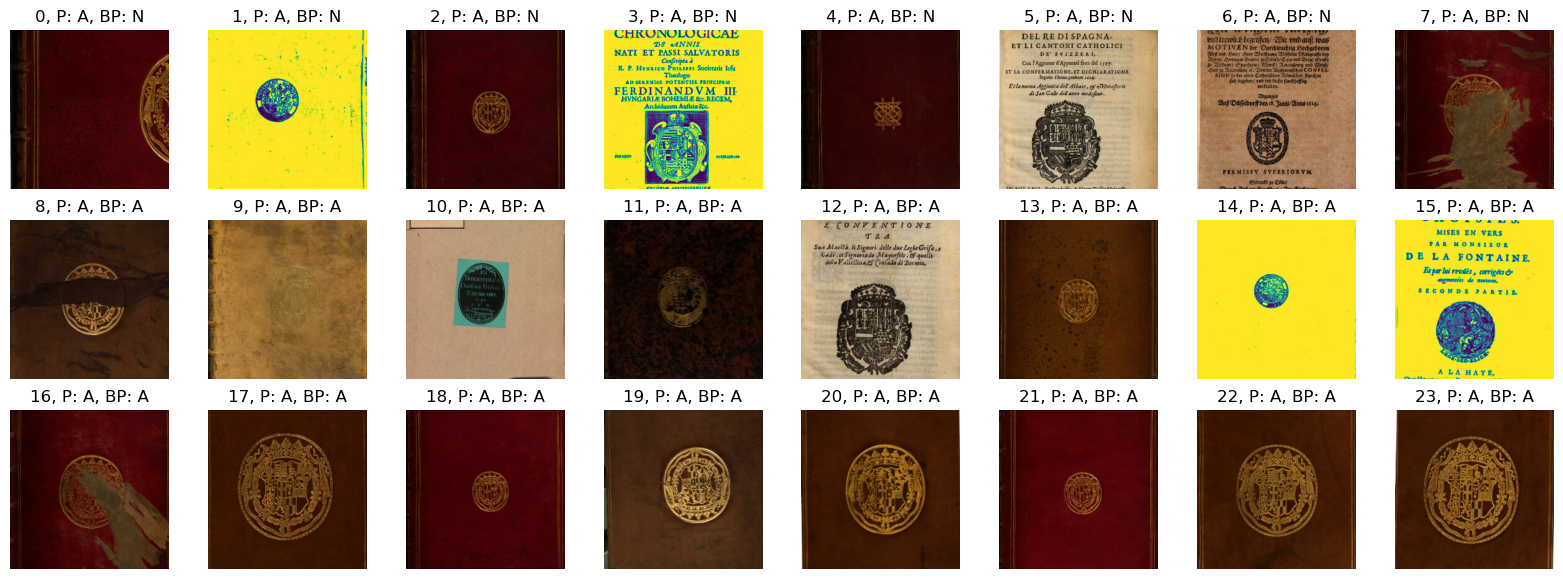

In [136]:
display_images_from_dataframe(pred_A.sort_values('p_A'), 24)
pred_A.sort_values('p_A').iloc[:24]

filename prediction   
272503  Z179010000_00000001.jpg          B  \
160660  Z183268807_00000001.jpg          B   
442007  Z203776604_00000001.jpg          B   
425252  Z18473310X_00000001.jpg          B   
414297  Z181593703_00000001.jpg          B   
241988  Z166437203_00000001.jpg          B   
488778  Z200809507_00000001.jpg          B   
8950    Z158912607_00000001.jpg          B   
486373  Z197446406_00000001.jpg          B   
300418  Z197993600_00000001.jpg          B   

                                              probability       p_A       p_B   
272503  [0.022900931537151337, 0.5634558796882629, 0.0...  0.022901  0.563456  \
160660  [0.025445988401770592, 0.578296422958374, 0.04...  0.025446  0.578296   
442007  [0.015066320076584816, 0.6043609380722046, 0.0...  0.015066  0.604361   
425252  [0.01275714673101902, 0.6206324696540833, 0.00...  0.012757  0.620632   
414297  [0.006056108046323061, 0.6504228115081787, 0.0...  0.006056  0.650423   
241988  [0.027653846889734268, 0.6626480221748352, 0.0...  0.027654  0.662648   
488778  [0.028262926265597343, 0.6668215990066528, 0.0...  0.028263  0.666822   
8950    [0.019999774172902107, 0.7283031940460205, 0.0...  0.020000  0.728303   
486373  [0.24129152297973633, 0.7559995651245117, 0.00...  0.241292  0.756000   
300418  [0.002050915500149131, 0.7643636465072632, 0.0...  0.002051  0.764364   

             p_C       p_N better_prediction      years  
272503  0.029261  0.384382                 N  1600_1650  
160660  0.048947  0.347310                 N  1550_1599  
442007  0.025455  0.355118                 B  1651_1699  
425252  0.003516  0.363094                 B  1651_1699  
414297  0.002006  0.341515                 B  1651_1699  
241988  0.023952  0.285746                 B  1600_1650  
488778  0.048427  0.256489                 B  1700_1738  
8950    0.049386  0.202311                 B  1501_1549  
486373  0.001934  0.000775                 B  1700_1738  
300418  0.001412  0.232174                 B  1600_1650

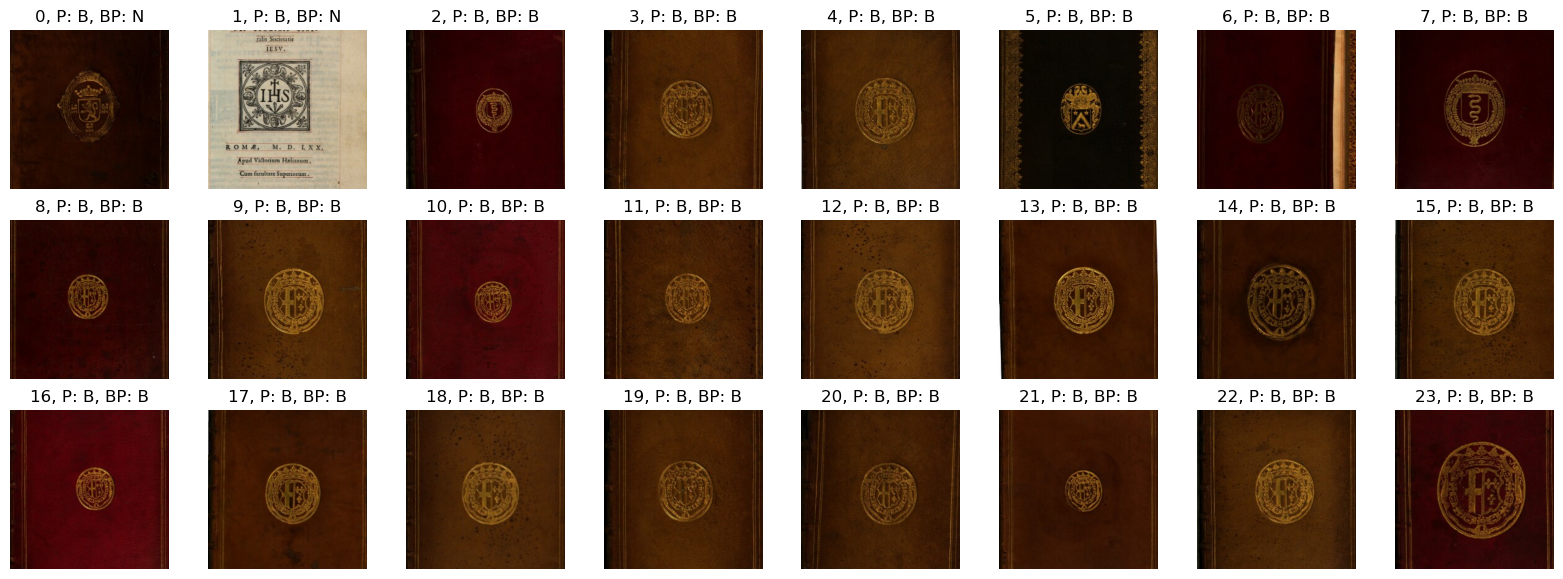

In [138]:
display_images_from_dataframe(pred_B.sort_values('p_B'), 24)
pred_B.sort_values('p_B').iloc[:10]

filename prediction   
427680  Z185539909_00000004.jpg          C  \
207936  Z254872704_00000002.jpg          C   
307801  Z205269606_00000004.jpg          C   
198895  Z221968101_00000001.jpg          C   
440970  Z203251908_00000004.jpg          C   
358626  Z163601107_00000004.jpg          C   
153      Z10520809_00000004.jpg          C   
240534  Z166059002_00000002.jpg          C   
307806  Z205269709_00000004.jpg          C   
106753  Z166065002_00000004.jpg          C   
417985  Z182705100_00000004.jpg          C   
417665  Z182641201_00000004.jpg          C   
311274  Z207197702_00000002.jpg          C   
368767  Z166073904_00000001.jpg          C   
63668   Z20327880X_00000004.jpg          C   
466623  Z227885205_00000002.jpg          C   
400160  Z17729140X_00000004.jpg          C   
385235  Z170421908_00000004.jpg          C   
483004  Z18380030X_00000002.jpg          C   
66145   Z205837001_00000001.jpg          C   
266556  Z177289908_00000004.jpg          C   
18770   Z168150501_00000001.jpg          C   
453742  Z207811301_00000001.jpg          C   
475976  Z16898140X_00000004.jpg          C   
30299   Z177498005_00000005.jpg          C   
332164  Z152357705_00000003.jpg          C   
291571  Z184795505_00000004.jpg          C   
35605   Z179426708_00000001.jpg          C   
261976  Z175799208_00000004.jpg          C   
420937  Z183567008_00000001.jpg          C   
15160   Z165660802_00000001.jpg          C   
239678  Z16575450X_00000001.jpg          C   
11405   Z161861503_00000001.jpg          C   
332154  Z152357407_00000003.jpg          C   
50240   Z18415410X_00000001.jpg          C   
336697  Z155916602_00000001.jpg          C   
405637  Z178910507_00000001.jpg          C   
445067  Z204644902_00000001.jpg          C   
395502  Z176011704_00000001.jpg          C   
307098  Z20464480X_00000001.jpg          C   

                                              probability       p_A       p_B   
427680  [0.18134024739265442, 0.1470518708229065, 0.34...  0.181340  0.147052  \
207936  [0.18115109205245972, 0.13492941856384277, 0.3...  0.181151  0.134929   
307801  [0.17337185144424438, 0.13368786871433258, 0.3...  0.173372  0.133688   
198895  [0.050154849886894226, 0.32586485147476196, 0....  0.050155  0.325865   
440970  [0.16942675411701202, 0.13279907405376434, 0.3...  0.169427  0.132799   
358626  [0.182157963514328, 0.12869572639465332, 0.361...  0.182158  0.128696   
153     [0.15015968680381775, 0.13539715111255646, 0.3...  0.150160  0.135397   
240534  [0.1417228728532791, 0.13460825383663177, 0.36...  0.141723  0.134608   
307806  [0.15584471821784973, 0.1310833841562271, 0.36...  0.155845  0.131083   
106753  [0.15317071974277496, 0.11101900786161423, 0.3...  0.153171  0.111019   
417985  [0.1969153881072998, 0.11423122882843018, 0.37...  0.196915  0.114231   
417665  [0.16222704946994781, 0.12465735524892807, 0.3...  0.162227  0.124657   
311274  [0.12606385350227356, 0.13442569971084595, 0.3...  0.126064  0.134426   
368767  [0.060679759830236435, 0.2565363347530365, 0.3...  0.060680  0.256536   
63668   [0.11988898366689682, 0.11906477063894272, 0.4...  0.119889  0.119065   
466623  [0.13774457573890686, 0.1366114616394043, 0.42...  0.137745  0.136611   
400160  [0.13829846680164337, 0.1386747509241104, 0.42...  0.138298  0.138675   
385235  [0.13489511609077454, 0.12456633895635605, 0.4...  0.134895  0.124566   
483004  [0.05570873245596886, 0.027897480875253677, 0....  0.055709  0.027897   
66145   [0.00707376841455698, 0.017244303598999977, 0....  0.007074  0.017244   
266556  [0.05569901317358017, 0.03459442779421806, 0.5...  0.055699  0.034594   
18770   [0.011353843845427036, 0.014725173823535442, 0...  0.011354  0.014725   
453742  [0.19069339334964752, 0.10429776459932327, 0.5...  0.190693  0.104298   
475976  [0.009200616739690304, 0.005508386995643377, 0...  0.009201  0.005508   
30299   [0.013988030143082142, 0.010626082308590412, 0...  0.013988  0.010626   
332164  [0.022422997280955315,

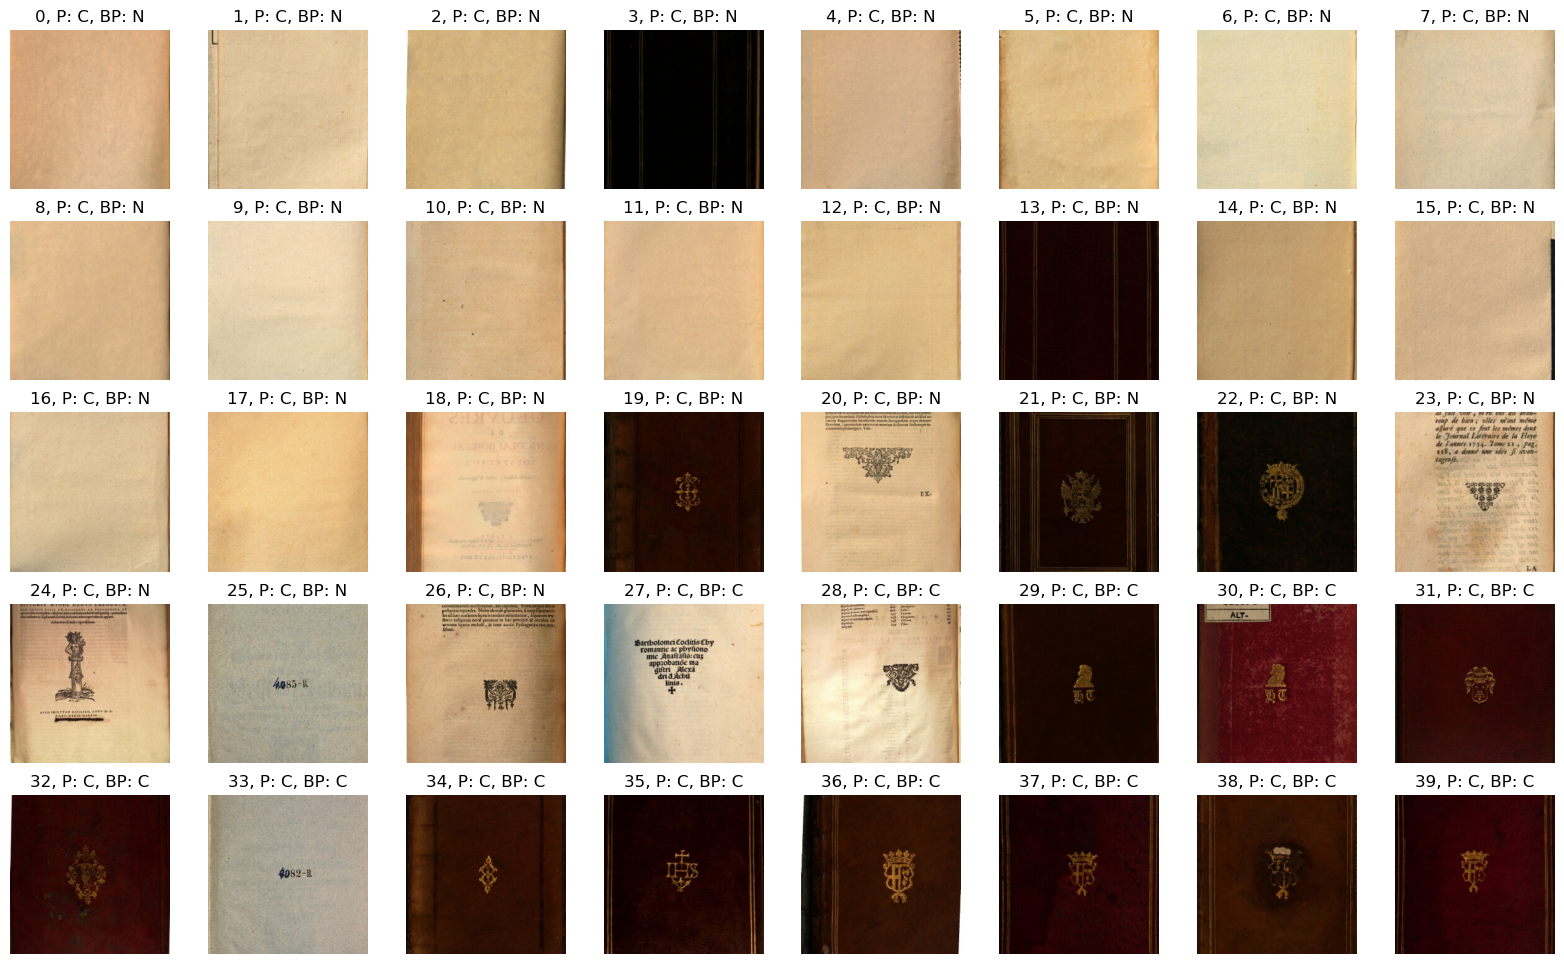

In [139]:
display_images_from_dataframe(pred_C.sort_values('p_C'), 40)
pred_C.sort_values('p_C').iloc[:40]